In [99]:
# Base PyTorch
import torch
from torch import nn

# PyTorch Vision
from torchvision import datasets, transforms

# Viz
import matplotlib.pyplot as plt

In [100]:
# Download datasets
train_dataset = datasets.FashionMNIST(root='data',
                                download=True,
                                train=True,
                                transform=transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root='data',
                                     download=True,
                                     train=False,
                                     transform=transforms.ToTensor())

CHW-format w/ img dimensionality in train dataset:  torch.Size([1, 28, 28])


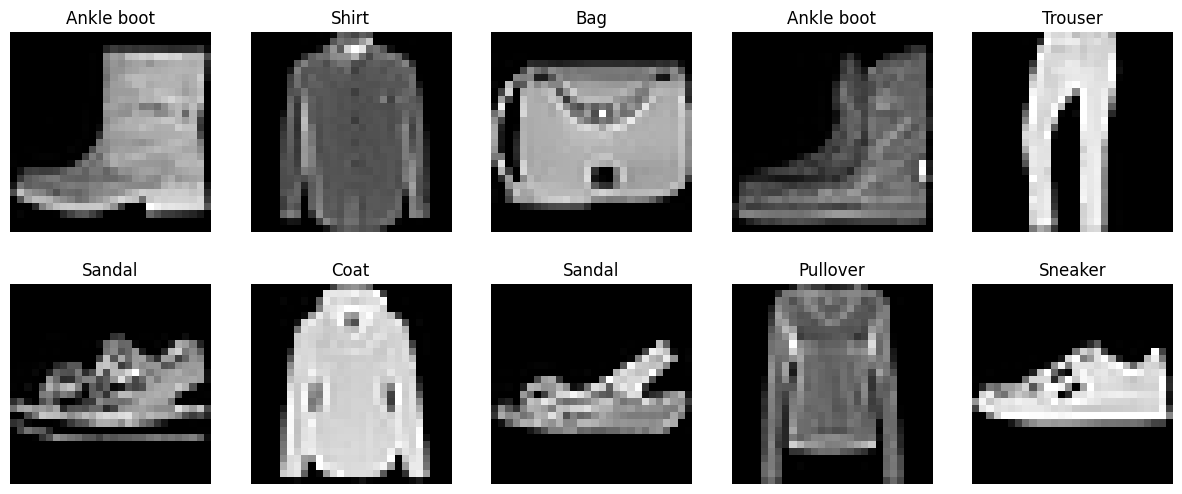

100%|██████████| 5/5 [01:44<00:00, 20.86s/it]


Accuracy on test set:  tensor(0.8699)
Time it took: 106.19412409899996


In [101]:
print("CHW-format w/ img dimensionality in train dataset: ", train_dataset[0][0].shape) if train_dataset[0][0].shape[0] == 1 else print("HWC-format w/ img dimensionality in train dataset: ", train_dataset[0][0].shape)

torch.manual_seed(42)
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
classes = train_dataset.classes

## Using CoPilot to visualize the dataset
# Generate some random images from the training dataset and label them using classes
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i in range(2):
    for j in range(5):
        idx = torch.randint(len(train_dataset), size=(1,)).item()
        img, label = train_dataset[idx]
        ax[i, j].imshow(img.squeeze(), cmap='gray')
        ax[i, j].set_title(classes[label])
        ax[i, j].axis('off')
plt.show()
### End of CoPilot

# Dataloader : making batches of data, much more computational efficient
BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                            batch_size=BATCH_SIZE,
                                                shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=BATCH_SIZE,
                                                shuffle=False)


# Build a baseline model

# Since this is a CNN problem, we will create a flatten layer
f = nn.Flatten()

class CNNmodel(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super().__init__()

        # First version
        # self.layer_stack = nn.Sequential(
        #     nn.Flatten(),
        #     # Probably start with 2 layers ~ Updated to 3
        #     nn.Linear(input_size,hidden_size),
        #     nn.ReLU(),  # Activation function
        #     nn.Linear(hidden_size,hidden_size),
        #     nn.ReLU(),
        #     nn.Linear(hidden_size,output_size),
        #     nn.ReLU()   # Output activation
        # )

        # Adding Conv layers
        self.conv_block = nn.Sequential(
            # kernel size : window size, padding : how much to cut out from image, stride : pixel movement
            nn.Conv2d(in_channels=input_size, out_channels=hidden_size, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Classifier layer
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_size*14*14, output_size)
        )
    
    def forward(self,x):
        x = self.conv_block(x)
        x = self.classifier(x)
        return x

# Predetermined hyperparameters : flattened size, neurons, outputs
# model = model(f(next(iter(train_loader))[0]).shape[1], 10, len(classes)).to(device=device)
model = CNNmodel(1, 10, len(classes)).to(device=device)

# Train loop
model.state_dict()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
# Probably use accuracy and f1 score as metrics

# Training viz and geeky metrics
from timeit import default_timer as timer
from tqdm.auto import tqdm
from torchmetrics import Accuracy
acc = Accuracy(task='multiclass', num_classes=len(classes)).to(device)

st = timer()
epochs = 5

for epoch in tqdm(range(epochs)):

    batch_loss, batch_acc = 0, 0
    model.train()

    for batch, (X,y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        delta = loss_fn(y_pred,y)
        batch_loss += delta

        optimizer.zero_grad()
        delta.backward()

        optimizer.step()

        batch_acc += acc(y_pred,y)
    
batch_loss /= len(train_loader)
batch_acc /= len(train_loader)

test_loss, test_acc = 0, 0
model.eval()
with torch.inference_mode():
    for X,y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        test_loss += loss_fn(y_pred,y)
        test_acc += acc(y_pred,y)

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

print("Accuracy on test set: ", test_acc)
print("Time it took:", (timer()-st))

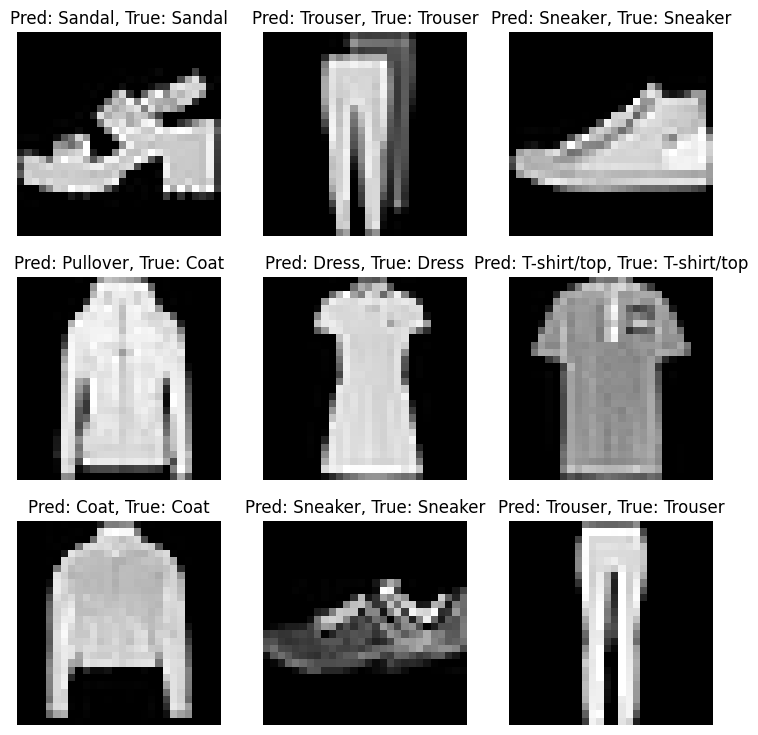

100%|██████████| 313/313 [00:01<00:00, 159.15it/s]


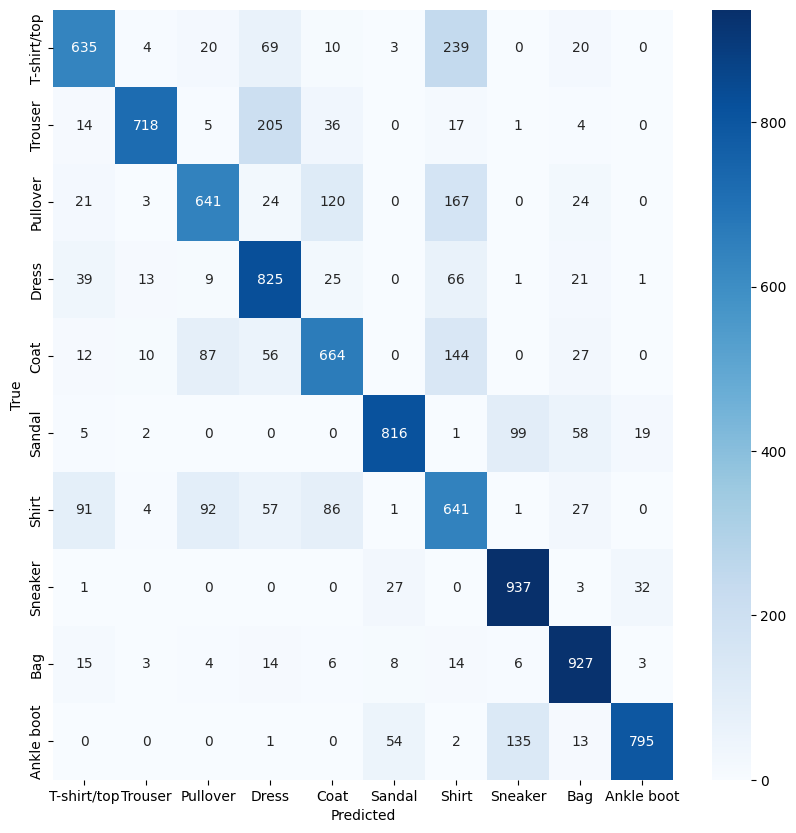

In [102]:
# Since model has at least 90% accuracy, let's try to use it
def predict(model, data, device='cpu'):
    prob_matrix = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for image in data:
            image = torch.unsqueeze(image, dim=0).to(device)
            logits = model(image)
            prob_matrix.append(torch.softmax(logits.squeeze(), dim=0).detach().cpu())
    return torch.stack(prob_matrix)


# Test deployment

import random
random.seed(42)
samples, labels = [], []
for image, label in random.sample(list(test_dataset), 9):
    samples.append(image)
    labels.append(label)

pred_probs = predict(model, samples)
pred_class = torch.argmax(pred_probs, dim=1)

# Easy viz
plt.figure(figsize=(9, 9))
r, c = 3, 3
for i, sample in enumerate(samples):
    plt.subplot(r, c, i+1)
    plt.imshow(sample.squeeze(), cmap='gray')
    pred_label = classes[pred_class[i]]
    true_label = classes[labels[i]]
    plt.title(f"Pred: {pred_label}, True: {true_label}")
    plt.axis('off')
plt.show()


# Main deployment
from torchmetrics import ConfusionMatrix
from seaborn import heatmap

y_preds = []
model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        y_preds.append(torch.softmax(y_pred.squeeze(), dim=0).argmax(dim=1).detach().cpu())

matrix = ConfusionMatrix(task='multiclass',num_classes=len(classes))
conf_mat = matrix(torch.cat(y_preds), test_dataset.targets)

# Confusion matrix viz
plt.figure(figsize=(10, 10))
heatmap(conf_mat.cpu(), annot=True, xticklabels=classes, yticklabels=classes, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()